In [1]:
from IPython import display

from utils import Logger

import torch
from torch import nn
from torch.optim import Adam

from torchvision import transforms, datasets
import sys
sys.path.append("..")
from sagan import Generator, Discriminator

In [2]:
DATA_FOLDER = './torch_data/CIFAR'

In [3]:
# torch.device object used throughout this script
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

## Load data

In [4]:
def cifar_data():
    compose = transforms.Compose(
        [
            transforms.Resize(64),
            transforms.ToTensor(),
            transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
    out_dir = '{}/dataset'.format(DATA_FOLDER)
    return datasets.CIFAR10(root=out_dir, train=True, transform=compose, download=True)

In [5]:
data = cifar_data()
batch_size = 100
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
num_batches = len(data_loader)

Files already downloaded and verified


In [6]:
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)

In [7]:
# Noise
def noise(size, z_dim):
    return torch.randn(size, z_dim).to(device)

In [8]:
imsize = 64
g_num = 5
z_dim = 128
g_conv_dim = 64
d_conv_dim = 64
lambda_gp = 10

# Training setting
total_step = 1000000
d_iters = 5
batch_size = 64
lr_decay = 0.95

In [9]:
# Create Network instances and init weights
generator = Generator(batch_size, imsize, z_dim, g_conv_dim).to(device)
# generator.apply(init_weights)

discriminator = Discriminator(batch_size, imsize, d_conv_dim).to(device)
# discriminator.apply(init_weights)

# Enable cuda if available

In [10]:
# Optimizers
d_optimizer = Adam(filter(lambda p: p.requires_grad, discriminator.parameters()), 
                   lr=0.0004, betas=(0.0, 0.9))
g_optimizer = Adam(filter(lambda p: p.requires_grad, generator.parameters()),
                   lr=0.0001, betas=(0.0, 0.9))

# Loss function
loss = nn.CrossEntropyLoss()

# Number of epochs
num_epochs = 200

In [15]:
def train_discriminator(optimizer, real_data, fake_data):    
    # Reset gradients
    size = real_data.size(0)
    
    # 1.1 Train on Real Data, dr1 and dr2 are attention scores
    prediction_real, dr1, dr2 = discriminator(real_data)
    # Calculate error
    error_real = - torch.mean(prediction_real)

    # 1.2 Train on Fake Data  
    z = noise(size, z_dim)
    fake_data, gf1, gf2 = generator(z)
    prediction_fake, df1, df2 = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = prediction_fake.mean()
    
    loss = error_real + error_fake
    optimizer.zero_grad()
    loss.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Compute gradient penalty
    alpha = torch.rand(real_data.size(0), 1, 1, 1).to(device).expand_as(real_data)
    interpolated = alpha * real_data.data + (1 - alpha) * fake_data.data
    interpolated.requires_grad = True
    out, _, _ = discriminator(interpolated)

    grad = torch.autograd.grad(outputs=out,
                               inputs=interpolated,
                               grad_outputs=torch.ones(out.size()).to(device),
                               retain_graph=True,
                               create_graph=True,
                               only_inputs=True)[0]

    grad = grad.view(grad.size(0), -1)
    grad_l2norm = torch.sqrt(torch.sum(grad ** 2, dim=1))
    d_loss_gp = torch.mean((grad_l2norm - 1) ** 2)

    # Backward + Optimize
    d_loss = lambda_gp * d_loss_gp

    optimizer.zero_grad()
    d_loss.backward()
    optimizer.step()
    
    # Return error
    return loss, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
                      
    # Sample noise and generate fake data
    prediction, _, _ = discriminator(fake_data)
    # Calculate error and backpropagate
    error = -prediction.mean()
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

## Generate samples for testing

In [16]:
num_test_samples = 16
test_noise = noise(num_test_samples, z_dim)

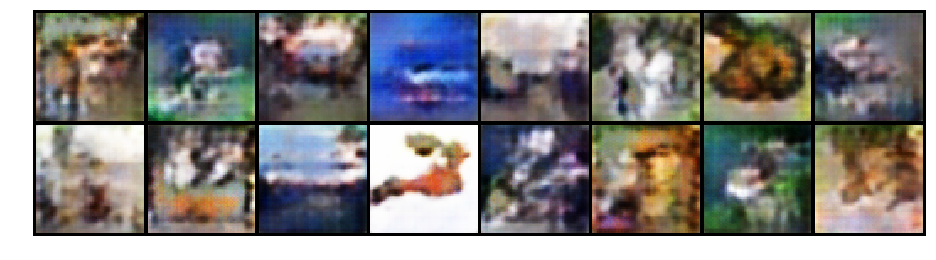

Epoch: [5/200], Batch Num: [0/500]
Discriminator Loss: -0.4984, Generator Loss: -19.6698
D(x): 23.9177, D(G(z)): 23.4193


KeyboardInterrupt: 

In [17]:
logger = Logger(model_name='SAGAN', data_name='CIFAR10')

for epoch in range(num_epochs):
    for n_batch, (real_data, _) in enumerate(data_loader):
        
        # 1. Train Discriminator
        real_data = real_data.to(device)
        # Generate fake data
        fake_data, _, _ = generator(noise(real_data.size(0), z_dim))
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, 
                                                                real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data, _, _ = generator(noise(real_data.size(0), z_dim))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        
        # Display Progress
        if (n_batch) % 100 == 0:
            display.clear_output(True)
            # Display Images
            test_images, _, _ = generator(test_noise)
            test_images = test_images.data.cpu()
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
        # Model Checkpoints
        logger.save_models(generator, discriminator, epoch)